15.1 A portfolio manager intends to launch a strategy that targets anannualized SR of  
2. Bets have a precision rate of 60%,with weekly frequency.The exit conditions  
are 2% for profit-taking, and –2% for stop-loss.  

(a) Is this strategy viable?

원하는 sharpe에 도달하지 못하였으므로 생존이 불가능하다.


In [1]:
import math
import numpy as np
import pandas as pd

def get_annualized_sharpe_ratio(precision, pt, sl, number_of_trades, **kwargs):
    expected_return = precision * pt + (1 - precision) * sl
    variance = precision * pt**2 + (1 - precision) * sl**2 - expected_return**2
    sharpe_ratio = expected_return / variance**0.5
    annualized_sharpe_ratio = sharpe_ratio * (number_of_trades**0.5)
    return annualized_sharpe_ratio

precision=0.6
pt=0.02
sl=-0.02

annualized_sharpe_ratio = get_annualized_sharpe_ratio(precision, pt, sl, 52)
print(f"Annualized Sharpe Ratio: {annualized_sharpe_ratio:.4f}")

Annualized Sharpe Ratio: 1.4720


(b) Ceteris paribus, what is the required precision rate that would make the
strategy profitable?

In [2]:
from sympy import symbols, Eq, solve

def get_target_precision(target_sharpe_ratio, pt, sl, freq):
    a=(freq+target_sharpe_ratio**2)*(pt-sl)**2
    b=(2*freq*sl-target_sharpe_ratio**2*(pt-sl))*(pt-sl)
    c=freq*sl**2
    x=symbols('x')
    eq = Eq(a*x**2 + b*x + c, 0)
    solutions = solve(eq, x)
    solutions=[s for s in solutions if s.is_real and s > 0]
    if not solutions:
        return None
    return max(solutions)

target_precision=get_target_precision(2.0, 0.02, -0.02, 52)
print(f"Target Precision: {target_precision:.4f}")



Target Precision: 0.6336


(c) For what betting frequency is the target achievable?

In [3]:
def get_target_bet_size(target_sharpe_ratio, pt, sl, precision):
    expected_return = precision * pt + (1 - precision) * sl
    variance = precision * pt**2 + (1 - precision) * sl**2 - expected_return**2
    sharpe_ratio = expected_return / variance**0.5
    return round((target_sharpe_ratio/sharpe_ratio)**2)

target_bet_size = get_target_bet_size(2.0, 0.02, -0.02, 0.6)
print(f"Target Bet Size: {target_bet_size}")

Target Bet Size: 96


(d) For what profit-taking threshold is the target achievable?

In [4]:
def get_target_profit_taking(target_sharpe_ratio, precision, sl, freq):
    temp=target_sharpe_ratio*np.sqrt(precision*(1-precision))/np.sqrt(freq)-precision
    return sl*(1+1/temp)

target_profit_taking = get_target_profit_taking(2.0, 0.6, -0.02, 52)
print(f"Target Profit Taking: {target_profit_taking:.4f}")

Target Profit Taking: 0.0231


(e) What Would be an alternative stop-loss?

In [5]:
def get_target_stop_loss(target_sharpe_ratio, precision, pt, freq):
    temp=target_sharpe_ratio*np.sqrt(precision*(1-precision))/np.sqrt(freq)-precision
    return pt/(1+1/temp)

target_stop_loss = get_target_stop_loss(2.0, 0.6, 0.02, 52)
print(f"Target Stop Loss: {target_stop_loss:.4f}")

Target Stop Loss: -0.0173


15.2 Following up on the strategy from exercise 1.

(a) What is the sensitivity of SR to a 1% change in each parameter? 

precision에 가장 민감하다

In [6]:
import inspect

def get_partial_derivative(precision, pt, sl, number_of_trades, diff_ratio=0.01, target_parameter='pt'):
    frame=inspect.currentframe()
    args, _, _, values = inspect.getargvalues(frame)
    if target_parameter not in args:
        raise ValueError(f"Parameter '{target_parameter}' not found in function arguments.")
    
    original_target=get_annualized_sharpe_ratio(precision, pt, sl, number_of_trades)
    param_map={arg: values[arg] for arg in args}
    param_map[target_parameter] *= (1 + diff_ratio)
    new_target=get_annualized_sharpe_ratio(**param_map)
    param_map[target_parameter] /= (1 + diff_ratio)
    param_map[target_parameter] *= (1 - diff_ratio)
    new_target2=get_annualized_sharpe_ratio(**param_map)
    return ((original_target-new_target2)/diff_ratio+(new_target-new_target2)/diff_ratio)/2

for param in ['precision', 'pt', 'sl', 'number_of_trades']:
    diff = get_partial_derivative(0.6, 0.02, -0.02, 52, target_parameter=param)
    print(f"Difference for {param}: {diff:.4f}")

Difference for precision: 13.7836
Difference for pt: 5.5292
Difference for sl: -5.5292
Difference for number_of_trades: 1.1049


(b) Given these sensitivities,and assuming that all parameters are equally hard  
to improve, which one offers the lowest hanging fruit?  

모두 개선하기는 난이도가 비슷하다면 Precision을 개선하는 것이 가장 쉬운 방법일 것이다.

(c) Does changing any of the parameters in exercise 1 impact the others ? For
example, does changing the betting frequency modify the precision rate,
etc.?

그럴수 있을 것이다. precision을 개선하기 위해서 특정정보를 사용한다고 가정했을때 해당 정보의 주기가 현재 거래 주기보다 길때 freq를 더 길게 가져가게 될 수 있다.

15.3 Suppose a strategy that generates monthly bets over two years, with returns  
following a mixture of two Gaussian distributions. The first distribution has  
a mean of –0.1 and a standard deviation of 0.12. The second distribution has  
a mean of 0.06 and a standard deviation of 0.03. The probability that a draw  
comes from the first distribution is 0.15.

(a) Following L´ opez de Prado and Peijan[2004] and L´ opezde Prado and Fore-
man [2014], derive the first four moments for the mixture’s returns.

In [7]:
from ef3m import EF3M

mu1=-0.1
sigma1=0.12
mu2=0.06
sigma2=0.03
p1=0.15

ef3m_instance=EF3M()
moments=ef3m_instance.get_moments(mu1, sigma1, mu2, sigma2, p1)
moments_names=['mean', 'variance', 'skewness', 'kurtosis', '5th moment']
for name, value in zip(moments_names, moments):
    print(f"{name.capitalize()}: {value:.4f}")

Mean: 0.0870
Variance: 0.0150
Skewness: 0.0014
Kurtosis: 0.0003
5th moment: 0.0001


(b) What is the annualized SR?

In [8]:
sr=moments[0] / moments[1]**0.5
number_of_trades=24
asr=sr * (number_of_trades**0.5)
print(f"Annualized Sharpe Ratio: {asr:.4f}")

Annualized Sharpe Ratio: 3.4748


(c) Using those moments, compute PSR[1] (see Chapter 14). At a 95% confi-
dence level, would you discard this strategy?

PSR이 99.52%이므로 strategy를 discard하지 않을 것이다.

In [9]:
from scipy.stats import norm
import numpy as np

def get_psr(bm_sr, moments, number_of_trades):
    ob_mean, ob_variance, ob_skewness, ob_kurtosis, ob_5th_moment = moments
    ob_sr=ob_mean/ob_variance**0.5
    t_value=(ob_sr-bm_sr)*np.sqrt(number_of_trades-1)/np.sqrt(1-ob_skewness*ob_sr+(ob_kurtosis-1)/4*ob_sr**2)
    return norm.cdf(t_value)

psr=get_psr(1/np.sqrt(number_of_trades), moments, number_of_trades)
print(f"Probability of Superior Returns (PSR): {psr:.4f}")

Probability of Superior Returns (PSR): 0.9952


15.4 Using Snippet15.5, compute P[p < p𝜃∗=1] for the strategy described in exercise  
3. At a significance level of 0.05, would you discard this strategy ? Is this result  
consistent with PSR[𝜃∗]?  

유의수준 0.05를 훨씬 초과한 38.7%가 나오므로 이 전략을 폐기해야한다, 이는 PSR의 결과와 일치하지 않는다.

In [10]:
def get_mix_gaussian_samples(mu1, sigma1, mu2, sigma2, p1, n_samples):
        n1 = int(n_samples * p1)
        n2 = n_samples - n1
        samples1 = np.random.normal(mu1, sigma1, n1)
        samples2 = np.random.normal(mu2, sigma2, n2)
        ret=np.concatenate((samples1, samples2))
        np.random.shuffle(ret)
        return ret

def get_prob_failure(target_sr, freq, samples:np.ndarray):
    mean_pos, mean_neg = np.mean(samples[samples > 0]), np.mean(samples[samples <= 0])
    precision=samples[samples > 0].shape[0]/samples.shape[0]
    target_precision = get_target_precision(target_sr, mean_pos, mean_neg, freq)
    risk=norm.cdf(float(target_precision), loc=precision, scale=np.sqrt(precision*(1-precision)))
    return risk

n_samples = 10000
samples = get_mix_gaussian_samples(mu1, sigma1, mu2, sigma2, p1, n_samples)
target_sr = 1.0
freq=24
prob_failure = get_prob_failure(target_sr, freq, samples)
print(f"Probability of Failure: {prob_failure:.4f}")

    

Probability of Failure: 0.3789


15.5 In general, what result do you expect to be more accurate, PSR[𝜃∗] or
P[p < p𝜃∗=1]?   How are these two methods complementary?

P[p < p𝜃∗=1]는 EF3M을 통해서 현재 포트폴리오 매니저의 제어안에서 발생한 return 결과인지 아닌지를 판단할 수 있어 좀 더 정확할 것이다. (pt, sl, number_of_trades) 활용
PSR은 실제 전략이 통계적으로 유의한가를 판단하고, P[p < p𝜃∗=1]는 전략을 버릴지 말지에 대한 평가를 하거나 전략을 디자인하는데 활용할 수 있다.

15.6 Re-examine the results from Chapter 13, in light of what you have learned in
thischapter.

(a) Does the asymmetry between profit taking and stop-loss thresholds in OTRs
make sense?

위의 get_target_stop_loss와 get_target_profit_taking의 함수가 완전히 일치하지 않으므로
전략을 달성하기 위한 최선의 profit-taking과 stop-loss가 완전히 대칭형태가 아니다, 따라서 유의미하다


(b) What is the range of p implied by Figure13.1 ,for a daily betting frequency?

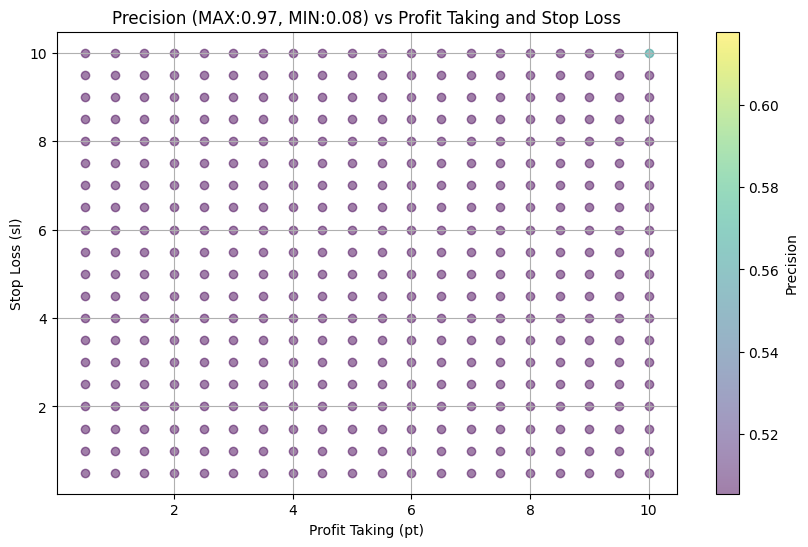

In [11]:
from itertools import product

rule_pt=rule_sl=np.linspace(0.5, 10, 20)
def get_trading_sharpe_by_ou_process(params, iter_cnt=1e3, max_hold_period=100, 
                                      seed_price=100, rule_pt=rule_pt, rule_sl=rule_sl, bet_freq=1):
    phi=2**(-1/params['hold_time'])
    ret=pd.DataFrame(index=rule_pt, columns=rule_sl, 
                     data=np.zeros((len(rule_pt), len(rule_sl))))
    for pt, sl in product(rule_pt, rule_sl):
        temp=[]
        for _ in range(int(iter_cnt)):
            cur_price=seed_price
            for i in range(max_hold_period):
                cur_price=(1-phi)*params['forecast']+phi*cur_price+ np.random.normal(0, params['sigma'])
                price_diff=cur_price-seed_price
                if ((i+1)%bet_freq==0 and (price_diff >pt or price_diff < -sl)) or i==max_hold_period-1:
                    temp.append(price_diff)
                    break
        mean_ret=np.mean(temp)
        std_ret=np.std(temp)
        sharpe=(mean_ret/std_ret) if std_ret != 0 else 0
        ret.loc[pt, sl]=sharpe
    return ret

params = {
    'forecast': 0,
    'sigma':1,
    'hold_time':5
}

sharpe_df = get_trading_sharpe_by_ou_process(params, iter_cnt=1e4)
precision_list=[]
max_precision=0
min_precision=float('inf')
for pt, sl in product(rule_pt, rule_sl):
    sr= sharpe_df.loc[pt, sl]
    p=get_target_precision(sr, pt, -sl, 1e4)
    precision_list.append((pt, sl, p))
    if p is not None:
        max_precision = max(max_precision, p)
        min_precision = min(min_precision, p)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for pt, sl, precision in precision_list:
    plt.scatter(pt, sl, c=precision, cmap='viridis', alpha=0.5)
plt.colorbar(label=f'Precision')
plt.xlabel('Profit Taking (pt)')
plt.ylabel('Stop Loss (sl)')
plt.title(f'Precision (MAX:{max_precision:.2f}, MIN:{min_precision:.2f}) vs Profit Taking and Stop Loss')
plt.grid()
plt.show()

(c) What is the range of p implied by Figure 13.5, for a weekly betting frequency?

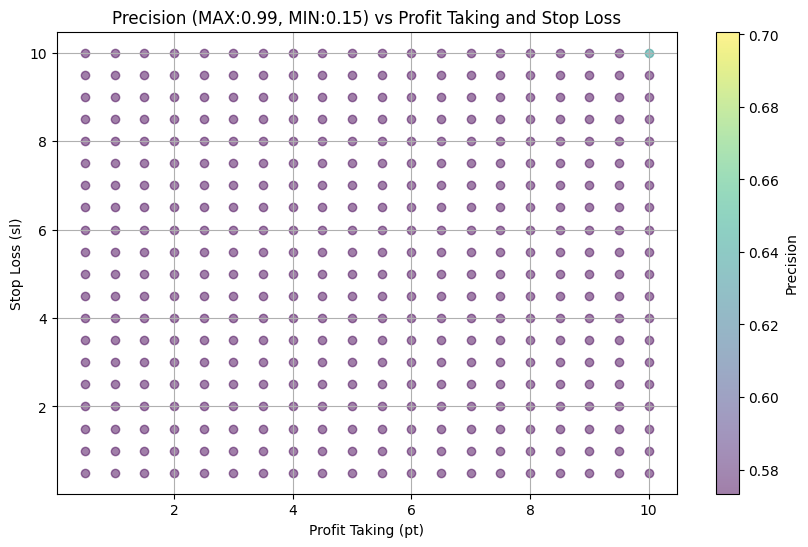

In [ ]:
sharpe_df = get_trading_sharpe_by_ou_process(params, iter_cnt=1e4, bet_freq=5)
precision_list=[]
max_precision = 0
min_precision = float('inf')
for pt, sl in product(rule_pt, rule_sl):
    sr= sharpe_df.loc[pt, sl]
    p=get_target_precision(sr, pt, -sl, 1e4)
    precision_list.append((pt, sl, p))
    max_precision = max(max_precision, p)
    min_precision = min(min_precision, p)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for pt, sl, precision in precision_list:
    plt.scatter(pt, sl, c=precision, cmap='viridis', alpha=0.5)
plt.colorbar(label=f'Precision')
plt.xlabel('Profit Taking (pt)')
plt.ylabel('Stop Loss (sl)')
plt.title(f'Precision (MAX:{max_precision:.2f}, MIN:{min_precision:.2f}) vs Profit Taking and Stop Loss')
plt.grid()
plt.show()
